## 1. Importando os dados coletados

In [59]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/cassiasamp/jul-20-calculadora-imoveis/master/coleta_de_dados/dados_mercado_livre.csv')

In [60]:
df.head()

,zona,precos,quartos,areas
0,norte,2990.0,3.0,475.0
1,norte,980000.0,2.0,55.0
2,norte,1700.0,2.0,58.0
3,norte,1350.0,NaN,28.0
4,norte,1000.0,3.0,55.0


In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
precos,1152.0,58433.302083,208259.538044,1000.0,1600.0,2420.0,4197.0,999000.0
quartos,1103.0,2.135086,0.895072,1.0,1.0,2.0,3.0,6.0
areas,1149.0,127.228895,354.052988,6.0,50.0,70.0,108.0,7800.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   zona     1152 non-null   object 
 1   precos   1152 non-null   float64
 2   quartos  1103 non-null   float64
 3   areas    1149 non-null   float64
dtypes: float64(3), object(1)
memory usage: 36.1+ KB


In [63]:
df['precos'] = df['precos'].astype('float')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   zona     1152 non-null   object 
 1   precos   1152 non-null   float64
 2   quartos  1103 non-null   float64
 3   areas    1149 non-null   float64
dtypes: float64(3), object(1)
memory usage: 36.1+ KB


## 2. Fazendo a análise exploratória e o preprocessamento dos dados

In [65]:
from sklearn.model_selection import train_test_split

treino, teste = train_test_split(df, 
                                 stratify=df['zona'], # preserva a proporção original das zonas na amostra
                                 test_size=0.25, 
                                 random_state=0)

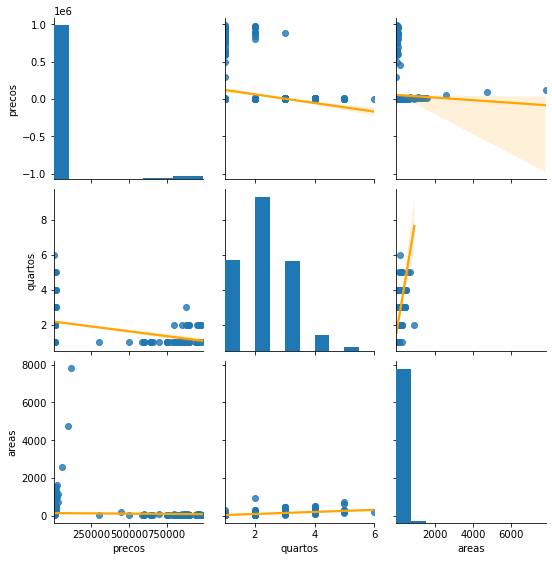

In [66]:
import seaborn as sns

sns.pairplot(treino, kind='reg', plot_kws={'line_kws':{'color':'orange'}});

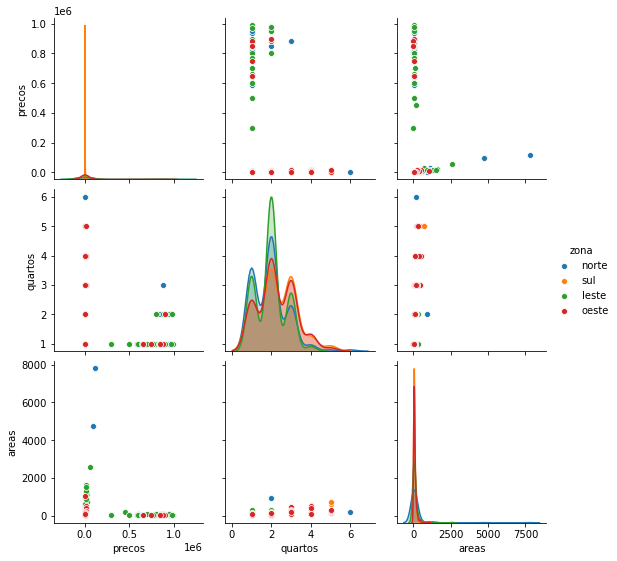

In [67]:
sns.pairplot(treino, hue='zona');

### 2.1 Tratando os dados numéricos




In [68]:
num_cols = ['quartos', 'areas', 'precos']
treino_num = treino[num_cols]

In [69]:
treino_num.head()

,quartos,areas,precos
18,2.0,75.0,1830.0
461,3.0,140.0,6900.0
249,2.0,45.0,2500.0
632,2.0,100.0,2200.0
458,1.0,40.0,3850.0


In [70]:
treino.isnull().sum()

zona        0
precos      0
quartos    39
areas       2
dtype: int64

In [71]:
# preenchendo valores faltantes com a mediana
treino_medianas = treino_num.median()

treino_num = treino_num.fillna(treino_medianas)
treino_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 18 to 620
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   quartos  864 non-null    float64
 1   areas    864 non-null    float64
 2   precos   864 non-null    float64
dtypes: float64(3)
memory usage: 27.0 KB


In [72]:
treino_num.isnull().sum()

quartos    0
areas      0
precos     0
dtype: int64

In [73]:
import numpy as np

# aplicando log1p nos dados numéricos
# log1p é o mesmo de log(1 + número), evita distorções no resultado para logs de números pequenos (que seriam zerados)
treino_num = treino_num.apply(np.log1p)

In [74]:
treino_num

,quartos,areas,precos
18,1.098612,4.330733,7.512618
461,1.386294,4.948760,8.839422
249,1.098612,3.828641,7.824446
632,1.098612,4.615121,7.696667
458,0.693147,3.713572,8.256088
...,...,...,...
450,1.386294,4.543295,7.836370
344,1.098612,3.988984,7.266129
699,1.098612,3.988984,7.791936
792,1.098612,6.803505,9.392745


In [75]:
treino_num.describe().T

,count,mean,std,min,25%,50%,75%,max
quartos,864.0,1.099592,0.278143,0.693147,1.098612,1.098612,1.386294,1.945910
areas,864.0,4.382877,0.759081,1.945910,3.931826,4.241327,4.672829,8.962007
precos,864.0,8.216120,1.536056,6.908755,7.399995,7.802191,8.321835,13.805461


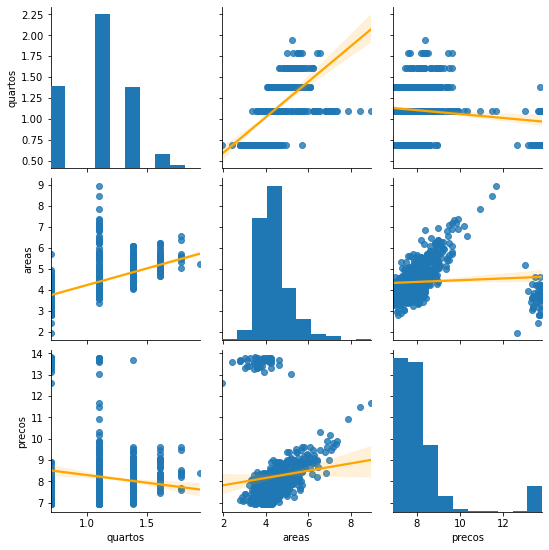

In [76]:
sns.pairplot(treino_num, kind='reg', plot_kws={'line_kws':{'color':'orange'}});

In [77]:
# fazendo ou não a remoção de outliers com IQR

REMOVER_OUTLIERS = False

quartis = treino_num.quantile([0.25, 0.5, 0.75])

Q1 = quartis.loc[0.25]
Q3 = quartis.loc[0.75]
IQR = Q3 - Q1

k = 1.5 
limite_inferior = Q1 - k * IQR
limite_superior = Q1 + k * IQR

# removendo valores nulos de IQR no treino
treino_num_sem_outlier = treino_num[treino_num >= limite_inferior].dropna()
treino_num_sem_outlier = treino_num_sem_outlier[treino_num_sem_outlier <= limite_superior].dropna()

if REMOVER_OUTLIERS:
    treino = treino.loc[treino_num_sem_outlier.index]

treino_num_sem_outlier

,quartos,areas,precos
18,1.098612,4.330733,7.512618
249,1.098612,3.828641,7.824446
632,1.098612,4.615121,7.696667
458,0.693147,3.713572,8.256088
439,1.098612,4.454347,7.919720
...,...,...,...
305,1.098612,5.017280,7.467942
450,1.386294,4.543295,7.836370
344,1.098612,3.988984,7.266129
699,1.098612,3.988984,7.791936


In [78]:
treino_num_sem_outlier.describe().T

,count,mean,std,min,25%,50%,75%,max
quartos,650.0,1.059419,0.242119,0.693147,0.693147,1.098612,1.098612,1.386294
areas,650.0,4.148756,0.396973,2.890372,3.912023,4.158883,4.394449,5.036953
precos,650.0,7.642927,0.439506,6.908755,7.280008,7.601402,7.939069,8.779711


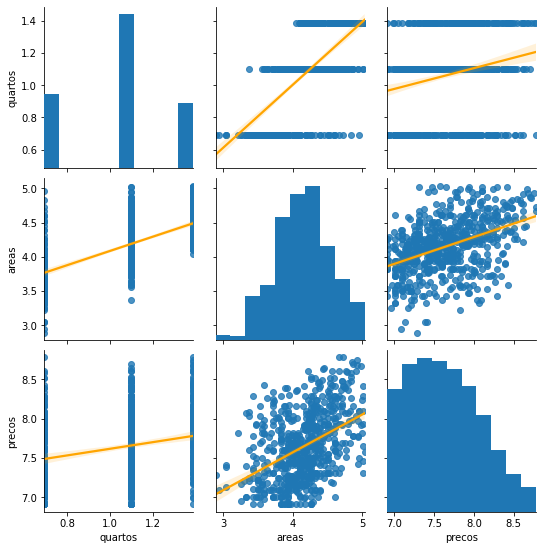

In [79]:
sns.pairplot(treino_num_sem_outlier, kind='reg', plot_kws={'line_kws':{'color':'orange'}});

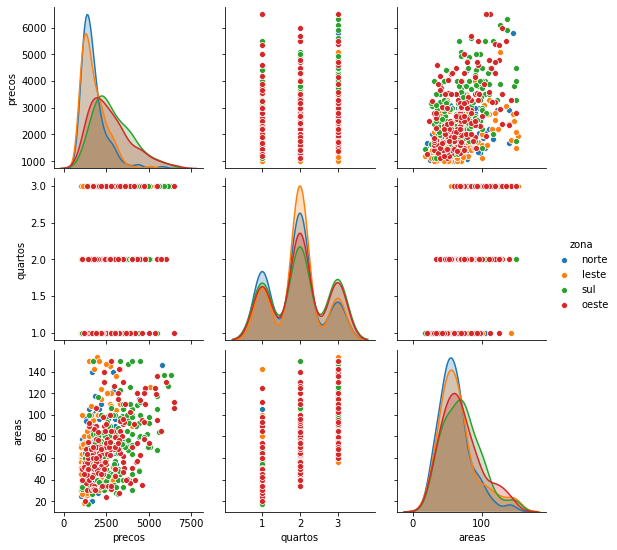

In [80]:
sns.pairplot(treino.loc[treino_num_sem_outlier.index], hue='zona');

### 2.2 Tratando colunas categóricas

In [81]:
cat_cols = ['zona']
treino_cat = treino[cat_cols]

In [82]:
# usando one hot encoding
treino_cat = pd.get_dummies(treino_cat)

In [83]:
treino_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 18 to 620
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   zona_leste  864 non-null    uint8
 1   zona_norte  864 non-null    uint8
 2   zona_oeste  864 non-null    uint8
 3   zona_sul    864 non-null    uint8
dtypes: uint8(4)
memory usage: 50.1 KB


In [84]:
treino = pd.concat([treino_cat, treino_num], axis=1)

In [86]:
treino.head()

,zona_leste,zona_norte,zona_oeste,zona_sul,quartos,areas,precos
18,0,1,0,0,1.098612,4.330733,7.512618
461,0,0,0,1,1.386294,4.948760,8.839422
249,0,1,0,0,1.098612,3.828641,7.824446
632,1,0,0,0,1.098612,4.615121,7.696667
458,0,0,0,1,0.693147,3.713572,8.256088


### 2.3 Repetindo o preprocessamentos para o conjunto de testes

In [87]:
# Preenchendo valores faltantes com medianas 

# Importante: NUNCA usar informações do conjunto de testes, por isso estamos usando as medianas do conjunto de treino
teste = teste.fillna(treino_medianas)
teste.head()

,zona,precos,quartos,areas
442,sul,2860.0,3.0,95.0
304,sul,3200.0,3.0,120.0
1078,oeste,4600.0,2.0,60.0
497,sul,2893.0,3.0,300.0
741,leste,1300.0,1.0,53.0


In [88]:
# aplicando log1p nos valores numericos
teste[num_cols] = teste[num_cols].apply(np.log1p)
teste.head()

,zona,precos,quartos,areas
442,sul,7.958926,1.386294,4.564348
304,sul,8.071219,1.386294,4.795791
1078,oeste,8.434029,1.098612,4.110874
497,sul,7.970395,1.386294,5.707110
741,leste,7.170888,0.693147,3.988984


In [89]:
# fazendo one hot encoding

teste_onehot = pd.get_dummies(teste[cat_cols])
teste=pd.concat([teste_onehot, teste[num_cols]], axis=1)
teste.head()

,zona_leste,zona_norte,zona_oeste,zona_sul,quartos,areas,precos
442,0,0,0,1,1.386294,4.564348,7.958926
304,0,0,0,1,1.386294,4.795791,8.071219
1078,0,0,1,0,1.098612,4.110874,8.434029
497,0,0,0,1,1.386294,5.707110,7.970395
741,1,0,0,0,0.693147,3.988984,7.170888


### 2.4 Salvando arquivos de treino e teste preprocessados

In [90]:
treino.to_csv('treino_preprocessado.csv', index=False)

In [91]:
teste.to_csv('teste_preprocessado.csv', index=False)